### PRELIMINARY

#### IMPORT

In [39]:
import numpy as np
from collections import namedtuple
import matplotlib.pyplot as plt
from numba import njit
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

#### MODEL PARAMETERS

In [2]:
Job_Search_RS = namedtuple("job_search_rs", 
                           ("n",                           # wage grid size
                            "m",                           # number of std
                            "ρ",                           # wage persistence
                            "ν",                           # wage volatility coefficent
                            "β",                           # discount factor
                            "c",                           # unemployment compensation
                            "θ"                            # Risk sensitivity
                           ))      

def create_job_search_rs_model(n=200, m=3,ρ=0.9, ν=0.2, β=0.98, c=1.0, θ=-0.2):
    return Job_Search_RS(n=n,m=m,ρ=ρ, ν=ν, β=β, c=c, θ=θ)

In [40]:
job_search_rs = create_job_search_rs_model()
job_search_rs

job_search_rs(n=200, m=3, ρ=0.9, ν=0.2, β=0.98, c=1.0, θ=-0.2)

#### TAUCHEN DISCRETIZATION

##### NORMAL CDF

In [41]:
@njit
def norm_cdf(x, mean=0, std=1):
    # Transform x to the standard normal
    z = (x - mean) / std
    
    # Use the Abramowitz & Stegun approximation for standard normal
    t = 1 / (1 + 0.2316419 * np.abs(z))
    d = 0.3989423 * np.exp(-z * z / 2)
    p = d * t * (0.3193815 + t * (-0.3565638 + t * (1.781478 + t * (-1.821256 + t * 1.330274))))
    
    return 1 - p if z > 0 else p

##### TAUCHEN DISCRETIZATION

In [45]:
@njit
def Tauchen(job_search_rs): # lower case for function name  
    n,m,ρ,ν,β,c,θ = job_search_rs                              # Unpack model parameters
    σ_w = np.sqrt(ν**2/(1-ρ**2))                               # W's std
    W = np.linspace(-m*σ_w, m*σ_w, n)                          # State space by Tauchen
    s = (W[n-1]-W[0])/(n-1)                                    # gap between two states
    P = np.zeros((n,n))                                        # Initialize P
    for i in range(n):
        P[i,0] = norm_cdf(W[0]-ρ*W[i]+s/2, std=σ_w)            # j=1
        P[i,n-1] = 1 - norm_cdf(W[n-1]-ρ*W[i]-s/2, std=σ_w)    # j=n
        for j in range(1,n-1):
            P[i,j] = norm_cdf(W[j]-ρ*W[i]+s/2, std=σ_w)-norm_cdf(W[j]-ρ*W[i]-s/2, std=σ_w)
    W = np.exp(W)                                              # positive wage
    return W,P

##### CHECK

In [44]:
W, P = Tauchen(job_search_rs)
np.sum(P, axis=1), W

(array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
 array([0.25246203, 0.25597889, 0.25954474, 0.26316027, 0.26682615,
        0.27054311, 0.27431184, 0.

#### VALUE AGGREGATOR

In [46]:
@njit
def B(v,σ, job_search_rs):
    n,m,ρ,ν,β,c,θ = job_search_rs                              # Unpack model parameters
    W, P = Tauchen(job_search_rs)                              # Wage space, Markov matrix

    e = W/(1-β)                                                # Stopping value
    h = c + β/θ * np.log(P@(np.exp(θ * v)))                    # Continuation value
    return σ * e + (1-σ) * h

#### GREEDY POLICY

In [47]:
@njit
def get_greedy(v, job_search_rs):
    n,m,ρ,ν,β,c,θ = job_search_rs                              # Unpack model parameters
    W, P = Tauchen(job_search_rs)                              # Wage space, Markov matrix

    e = W/(1-β)                                                # Stopping value
    h = c + β/θ * np.log(P@(np.exp(θ * v)))                    # Continuation value
    return np.where(e>=h, 1, 0)

#### OPI

In [28]:
@njit
def optimistic_policy_iteration(job_search_rs,
                                M=1,
                                tol=1e-6,
                                max_iter=10_000,
                                print_step=25
                               ):
    n,m,ρ,ν,β,c,θ = job_search_rs                              # Unpack model parameters
    W, P = Tauchen(job_search_rs)

    v = np.zeros(n)                                                #v_σ for always accept
    error = tol + 1 
    k=0

    while error > tol and k < max_iter:
        last_v = v
        σ = get_greedy(last_v, job_search_rs)
        for i in range(M):
            v = B(v,σ,job_search_rs)
        error = np.max(np.abs(last_v-v))
       # if k % print_step == 0:                                   
          #  print(f"Completed iteration {k} with error {error}.")
        k += 1
    if error <= tol:                                    
        #print(f"Terminated successfully in {k} interations.")
        v_star_opi = v
        σ_star_opi = get_greedy(v_star_opi, job_search_rs)
    else:     
        print("Warning: hit iteration bound.")
    return v_star_opi, σ_star_opi      

In [48]:
optimistic_policy_iteration(job_search_rs)

(array([ 66.45209209,  66.46344853,  66.47508324,  66.48699955,
         66.4992008 ,  66.51169029,  66.52447134,  66.53754723,
         66.55092128,  66.56459678,  66.57857702,  66.59286532,
         66.60746499,  66.62237937,  66.6376118 ,  66.65316567,
         66.66904437,  66.68525134,  66.70179005,  66.71866402,
         66.73587679,  66.753432  ,  66.77133329,  66.78958442,
         66.80818918,  66.82715144,  66.84647519,  66.86616445,
         66.88622337,  66.90665619,  66.92746726,  66.94866104,
         66.97024211,  66.99221518,  67.01458509,  67.03735683,
         67.06053552,  67.08412645,  67.10813507,  67.13256699,
         67.157428  ,  67.18272407,  67.20846137,  67.23464624,
         67.26128527,  67.28838519,  67.31595304,  67.34399599,
         67.37252151,  67.40153727,  67.43105118,  67.46107142,
         67.49160642,  67.52266485,  67.55425568,  67.58638811,
         67.61907166,  67.65231611,  67.68613153,  67.72052827,
         67.75551698,  67.79110862,  67.

#### PLOT

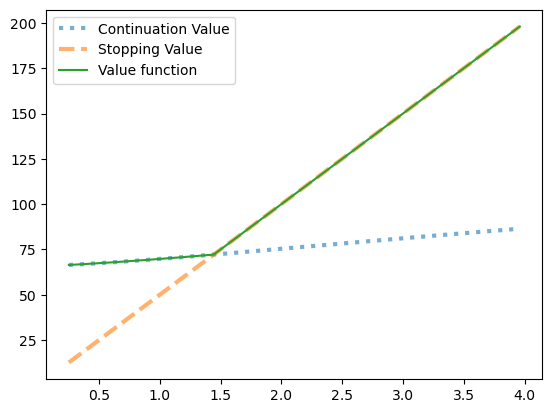

In [49]:
def plot_value_stopping_continue (job_search_rs):
    n,m,ρ,ν,β,c,θ = job_search_rs                              # Unpack model parameters
    W,P= Tauchen(job_search_rs)                             # Get W and P
    v_star_opi, σ_star_opi = optimistic_policy_iteration(job_search_rs) 
    h = c + β/θ * np.log(P@(np.exp(θ * v_star_opi)))                                       # Continuation value function
    e = W/(1-β)                                                  # Stopping value
    plt.plot(W, h, label='Continuation Value', linewidth=3, alpha=0.6, linestyle=':')
    plt.plot(W, e, label='Stopping Value',linewidth=3, alpha=0.6, linestyle='--')
    plt.plot(W, v_star_opi, label='Value function')
    plt.legend()
    plt.show()

plot_value_stopping_continue (job_search_rs)

### DIFFERENT VALUES OF $\theta$

In [50]:
def update_job_search_rs(job_search_rs, new_theta):
    # Create a new namedtuple with the updated theta
    return job_search_rs._replace(θ=new_theta)

def create_animation(initial_job_search_rs):
    fig, ax = plt.subplots()

    def update(frame):
        ax.clear()
        
        # Update theta and create new job_search_rs
        job_search_rs = update_job_search_rs(initial_job_search_rs, frame)
        
        
        n,m,ρ,ν,β,c,θ = job_search_rs 
        W, P = Tauchen(job_search_rs)  # Get W and P
        
        v_star_opi, σ_star_opi = optimistic_policy_iteration(job_search_rs)
        h = c + β/θ * np.log(P@(np.exp(θ * v_star_opi)))  # Continuation value function
        e = W / (1 - β)  # Stopping value
        
        ax.plot(W, h, label='Continuation Value', linewidth=3, alpha=0.6, linestyle=':')
        ax.plot(W, e, label='Stopping Value',linewidth=3, alpha=0.6, linestyle='--')
        ax.plot(W, v_star_opi, label='Value function')
        ax.legend()
        ax.set_title(f'θ = {frame:.2f}')

    theta_values = np.linspace(-1, 1, 50)  # Adjust the range of theta as needed
    anim = FuncAnimation(fig, update, frames=theta_values, interval=100, blit=False)
    
    return anim

# Create and display the animation
anim = create_animation(job_search_rs)
plt.close()
HTML(anim.to_jshtml())